# Predicting Wind Turbine Power Production using SCADA Data

# The columns descriptions:

- Date/Time : readings for 10 minutes intervals
- LV ActivePower (kW): The power generated by the turbine for that moment
- Wind Speed (m/s): The wind speed at the hub height of the turbine (the wind speed that turbine use for electricity generation)
- TheoreticalPowerCurve (kW): The theoretical power values that the turbine generates with that wind speed which is given by the turbine manufacturer
- Wind Direction (°): The wind direction at the hub height of the turbine (wind turbines turn to this direction automaticly)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')


In [3]:
data = pd.read_csv("https://raw.githubusercontent.com/amrhkm/wind-turbine-power-prediction/master/T1.csv?token=GHSAT0AAAAAAB5FQJBVQNMXWA4CHEHFPSRYZCPIHBA")
data.head()

,Date/Time,LV ActivePower (kW),Wind Speed (m/s),Theoretical_Power_Curve (KWh),Wind Direction (°)
0,01 01 2018 00:00,380.047791,5.311336,416.328908,259.994904
1,01 01 2018 00:10,453.769196,5.672167,519.917511,268.641113
2,01 01 2018 00:20,306.376587,5.216037,390.900016,272.564789
3,01 01 2018 00:30,419.645905,5.659674,516.127569,271.258087
4,01 01 2018 00:40,380.650696,5.577941,491.702972,265.674286


# Data Prep

## Renaming Columns

In [4]:
data = data.rename(columns={
    'LV ActivePower (kW)': 'power_kw',
    'Wind Speed (m/s)': 'wind_speed_ms',
    'Theoretical_Power_Curve (KWh)': 'theoretical_power_kw',
    'Wind Direction (°)': 'wind_direction_deg'
})

data.head()

,Date/Time,power_kw,wind_speed_ms,theoretical_power_kw,wind_direction_deg
0,01 01 2018 00:00,380.047791,5.311336,416.328908,259.994904
1,01 01 2018 00:10,453.769196,5.672167,519.917511,268.641113
2,01 01 2018 00:20,306.376587,5.216037,390.900016,272.564789
3,01 01 2018 00:30,419.645905,5.659674,516.127569,271.258087
4,01 01 2018 00:40,380.650696,5.577941,491.702972,265.674286


In [5]:
data.columns

Index(['Date/Time', 'power_kw', 'wind_speed_ms', 'theoretical_power_kw',
       'wind_direction_deg'],
      dtype='object')

In [6]:
data.shape

(50530, 5)

In [7]:
data.describe()

,power_kw,wind_speed_ms,theoretical_power_kw,wind_direction_deg
count,50530.000000,50530.000000,50530.000000,50530.000000
mean,1307.684332,7.557952,1492.175463,123.687559
std,1312.459242,4.227166,1368.018238,93.443736
min,-2.471405,0.000000,0.000000,0.000000
25%,50.677890,4.201395,161.328167,49.315437
50%,825.838074,7.104594,1063.776283,73.712978
75%,2482.507568,10.300020,2964.972462,201.696720
max,3618.732910,25.206011,3600.000000,359.997589


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50530 entries, 0 to 50529
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Date/Time             50530 non-null  object 
 1   power_kw              50530 non-null  float64
 2   wind_speed_ms         50530 non-null  float64
 3   theoretical_power_kw  50530 non-null  float64
 4   wind_direction_deg    50530 non-null  float64
dtypes: float64(4), object(1)
memory usage: 1.9+ MB


In [9]:
data.isnull().sum()

Date/Time               0
power_kw                0
wind_speed_ms           0
theoretical_power_kw    0
wind_direction_deg      0
dtype: int64

No null values

In [10]:
master_data = data.copy() #no changes done to this dataframe
df = data.copy() # to be manipulated

## Checking for outliers

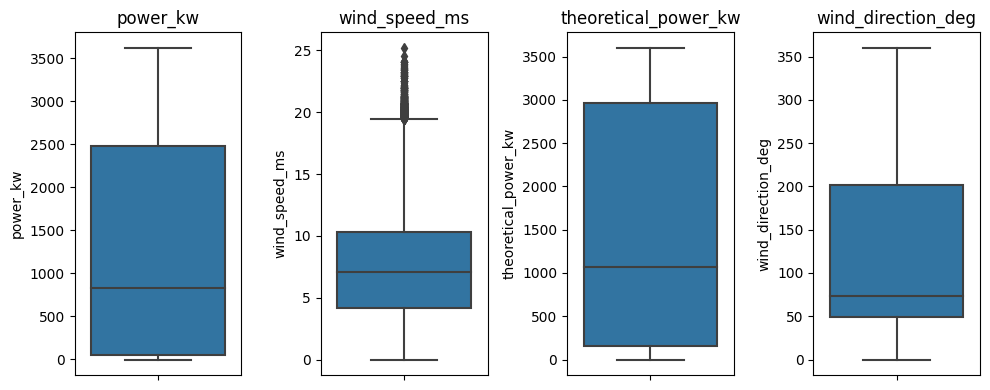

In [11]:
columns = ['power_kw', 'wind_speed_ms', 'theoretical_power_kw', 'wind_direction_deg']
i=1
plt.figure(figsize=(10,4))
for each in columns:
    plt.subplot(1,4,i)
    sns.boxplot(data = df, y= each)
    plt.title(each)
    plt.tight_layout()
    i += 1

we could see that only the column 'Wind_speed_ms' has an outlier

### Dealing with outliers

In [12]:
# checking for exact amout of outlier present
def detect_outliers_IQR(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return outliers

# to remove outliers using the IQR method
def remove_outliers_IQR(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    return df


In [13]:
column_names = ['power_kw', 'wind_speed_ms', 'theoretical_power_kw', 'wind_direction_deg']
for column in column_names:
    outliers = detect_outliers_IQR(df, column)
    print('Outliers for', column, ':', outliers.shape[0])
  

Outliers for power_kw : 0
Outliers for wind_speed_ms : 423
Outliers for theoretical_power_kw : 0
Outliers for wind_direction_deg : 0


the column Wind Speed has 423 outlier

In [14]:
outliers_wind_speed = detect_outliers_IQR(df, 'wind_speed_ms')
outliers_wind_speed['wind_speed_ms'].describe()


count    423.000000
mean      20.665708
std        1.158747
min       19.449539
25%       19.808920
50%       20.311859
75%       21.094854
max       25.206011
Name: wind_speed_ms, dtype: float64

In [15]:
print(f"The lowest wind speed within the outlier is {outliers_wind_speed['wind_speed_ms'].min()}")


The lowest wind speed within the outlier is 19.4495391845703


In [16]:
avg_power_by_out = df[(df['wind_speed_ms'] >= 19.4495391845703)]['power_kw'].mean()
print(f"Average Power Produced by outlier wind speed: {avg_power_by_out} kW")

Average Power Produced by outlier wind speed: 3571.6220905132586 kW


In [17]:
df[df['wind_speed_ms'] >= 19.4495391845703]

,Date/Time,power_kw,wind_speed_ms,theoretical_power_kw,wind_direction_deg
2396,17 01 2018 19:00,3460.064941,19.589029,3600.0,191.041000
2407,17 01 2018 20:50,3460.934082,20.408730,3600.0,190.896606
2408,17 01 2018 21:00,3460.278076,20.311640,3600.0,192.326599
2409,17 01 2018 21:10,3460.965088,20.203560,3600.0,194.577194
2410,17 01 2018 21:20,3461.021973,21.735920,3600.0,191.814102
...,...,...,...,...,...
49499,24 12 2018 20:10,3599.202881,20.886930,3600.0,209.078796
49500,24 12 2018 20:20,3599.352051,20.566700,3600.0,207.262207
49501,24 12 2018 20:30,3598.977051,20.452000,3600.0,206.919693
49502,24 12 2018 20:40,3599.501953,21.018150,3600.0,206.952499


### Replacing the outlier values for wind speed

#### Instead of removing all the outliers for the wind speed, any value larger than the minimum outlier value will be replace by 19 as their wind speed

In [18]:
df['wind_speed_ms'] = np.where( df['wind_speed_ms'] >= 19.4495391845703, 19, 1 * df['wind_speed_ms'] )

In [19]:
# checking if wind speed value higher than minimum outlier value still exist

df[df['wind_speed_ms'] >= 19.4495391845703]['wind_speed_ms'].count()

0

In [20]:
df[df['wind_speed_ms'] ==  19]['wind_speed_ms'].count()

423

#### 432 outlier wind speed was replaced by 19

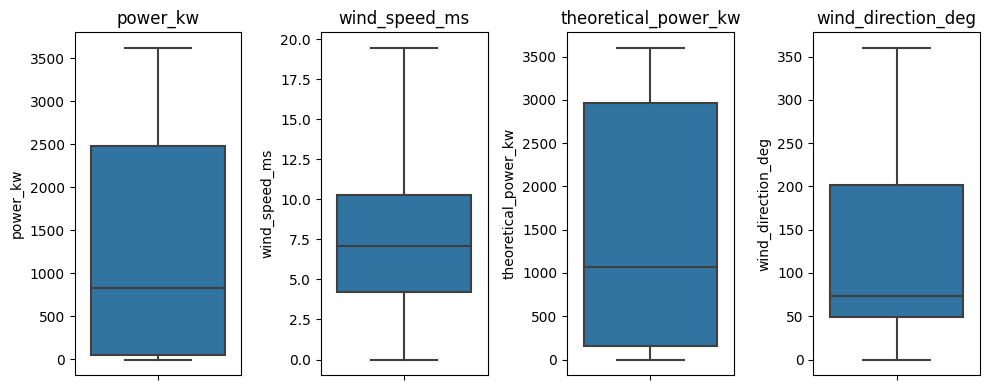

In [21]:
columns = ['power_kw', 'wind_speed_ms', 'theoretical_power_kw', 'wind_direction_deg']
i=1
plt.figure(figsize=(10,4))
for each in columns:
    plt.subplot(1,4,i)
    sns.boxplot(data = df, y= each)
    plt.title(each)
    plt.tight_layout()
    i += 1

Wind Speed outlier no longer present

In [22]:
column_names = ['power_kw', 'wind_speed_ms', 'theoretical_power_kw', 'wind_direction_deg']
for column in column_names:
    outliers = detect_outliers_IQR(df, column)
    print('Outliers for', column, ':', outliers.shape[0])

Outliers for power_kw : 0
Outliers for wind_speed_ms : 0
Outliers for theoretical_power_kw : 0
Outliers for wind_direction_deg : 0


## Dealing with date and time

In [23]:
df['Date/Time'] = pd.to_datetime(df['Date/Time'], format= "%d %m %Y %H:%M")

df['year'] = df['Date/Time'].dt.year
df['month'] = df['Date/Time'].dt.month
df['day'] = df['Date/Time'].dt.day
df['hour'] = df['Date/Time'].dt.hour

df.head()

,Date/Time,power_kw,wind_speed_ms,theoretical_power_kw,wind_direction_deg,year,month,day,hour
0,2018-01-01 00:00:00,380.047791,5.311336,416.328908,259.994904,2018,1,1,0
1,2018-01-01 00:10:00,453.769196,5.672167,519.917511,268.641113,2018,1,1,0
2,2018-01-01 00:20:00,306.376587,5.216037,390.900016,272.564789,2018,1,1,0
3,2018-01-01 00:30:00,419.645905,5.659674,516.127569,271.258087,2018,1,1,0
4,2018-01-01 00:40:00,380.650696,5.577941,491.702972,265.674286,2018,1,1,0


In [24]:
df = df.drop(['Date/Time'], axis=1)

In [25]:
df

,power_kw,wind_speed_ms,theoretical_power_kw,wind_direction_deg,year,month,day,hour
0,380.047791,5.311336,416.328908,259.994904,2018,1,1,0
1,453.769196,5.672167,519.917511,268.641113,2018,1,1,0
2,306.376587,5.216037,390.900016,272.564789,2018,1,1,0
3,419.645905,5.659674,516.127569,271.258087,2018,1,1,0
4,380.650696,5.577941,491.702972,265.674286,2018,1,1,0
...,...,...,...,...,...,...,...,...
50525,2963.980957,11.404030,3397.190793,80.502724,2018,12,31,23
50526,1684.353027,7.332648,1173.055771,84.062599,2018,12,31,23
50527,2201.106934,8.435358,1788.284755,84.742500,2018,12,31,23
50528,2515.694092,9.421366,2418.382503,84.297913,2018,12,31,23


In [27]:
import os

directory_path = r'C:\Users\hamir\Desktop\Wind Turbine'

file_name = os.path.join(directory_path, 'df.csv')

df.to_csv(file_name, index=False)


# EDA

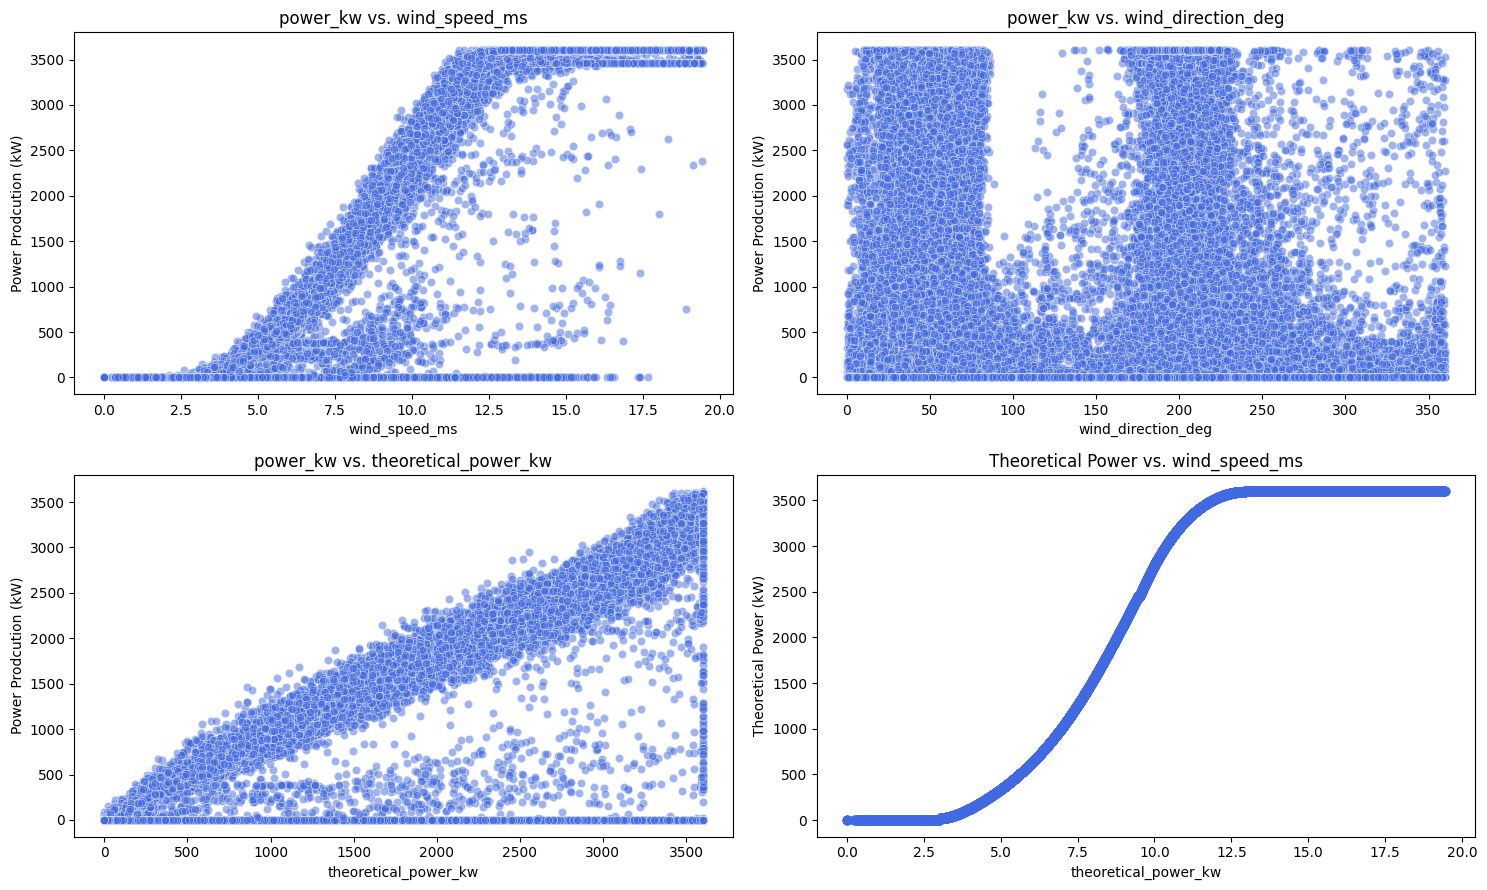

In [28]:
columns =  ['wind_speed_ms', 'wind_direction_deg', 'theoretical_power_kw',]
i=1
color = 'royalblue'
plt.figure(figsize=(15,9))
for each in columns:
    plt.subplot(2,2,i)
    #plt.scatter(df[each], df['power_kw'], alpha=0.3)
    sns.scatterplot(x= df[each], y= df['power_kw'], color= color, alpha=0.5, data= df)
    plt.xlabel(each)
    plt.ylabel('Power Prodcution (kW)')
    plt.title(f'power_kw vs. {each}')
    i += 1
    
plt.subplot(2,2,4)
plt.scatter(df['wind_speed_ms'], df['theoretical_power_kw'], color = color , alpha=0.5)
plt.xlabel(each)
plt.ylabel('Theoretical Power (kW)')
plt.title('Theoretical Power vs. wind_speed_ms')
plt.tight_layout()
plt.show()

- Both real power production and theoretical power production is highly correlated to the wind speed.
- For real power production, even after a certain wind speed, there is still a few datapoints with a very low power.
- For wind direction, there is a certain degree of angle (between around 80 to 170 and after 230) that produce very low power.

Text(0, 0.5, 'Power Production (kw)')

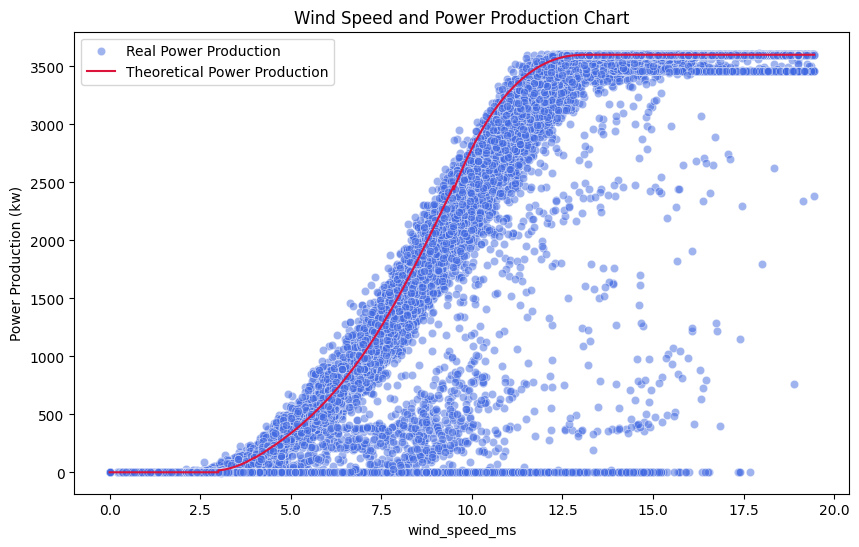

In [29]:
plt.figure(figsize=(10,6))
sns.scatterplot(x='wind_speed_ms', y='power_kw', color='royalblue', label='Real Power Production', alpha=0.5, data=df)
sns.lineplot(x='wind_speed_ms', y='theoretical_power_kw', color='crimson', label='Theoretical Power Production', data=df)
plt.title('Wind Speed and Power Production Chart')
plt.ylabel('Power Production (kw)')

In [30]:
power0 = df[df['power_kw'] == 0]
power0

,power_kw,wind_speed_ms,theoretical_power_kw,wind_direction_deg,year,month,day,hour
382,0.0,3.743307,83.986265,245.068207,2018,1,3,15
385,0.0,2.142016,0.000000,234.762405,2018,1,3,16
386,0.0,2.501406,0.000000,223.308807,2018,1,3,16
387,0.0,2.668578,0.000000,226.051697,2018,1,3,16
388,0.0,3.034003,17.180593,221.086502,2018,1,3,16
...,...,...,...,...,...,...,...,...
50465,0.0,2.998981,0.000000,76.018478,2018,12,31,13
50466,0.0,2.647908,0.000000,78.276291,2018,12,31,13
50467,0.0,2.796982,0.000000,68.145531,2018,12,31,13
50468,0.0,3.670288,73.392108,71.954659,2018,12,31,13


there is 10781 datapoints where the power is equal to 0

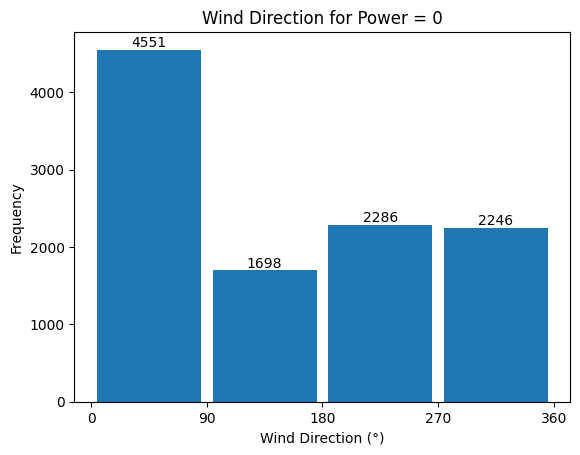

In [31]:
fig, ax = plt.subplots()
n, bins, patches = ax.hist(power0['wind_direction_deg'], bins=4, rwidth=0.9)

ax.set_title('Wind Direction for Power = 0')
ax.set_xlabel('Wind Direction (°)')
ax.set_ylabel('Frequency')
plt.xticks([0, 90, 180, 270, 360])

for i in range(len(patches)):
    x = patches[i].get_x() + patches[i].get_width() / 2
    y = patches[i].get_height()
    ax.text(x, y, f'{int(y)}', ha='center', va='bottom')

plt.show()


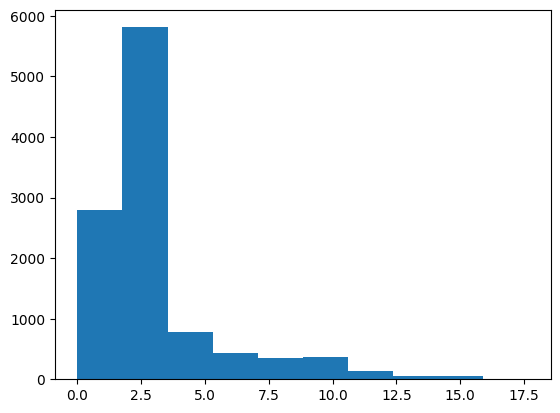

In [32]:
plt.hist(power0['wind_speed_ms'])

plt.show()

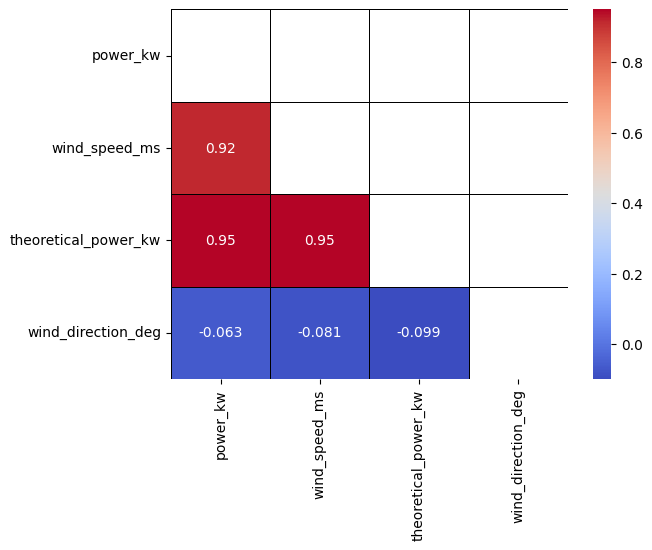

In [33]:
# Compute the correlation matrix
corr_matrix = df[['power_kw', 'wind_speed_ms', 'theoretical_power_kw', 'wind_direction_deg']].corr()

# Create a boolean mask to hide the upper triangular part of the matrix
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Create a heatmap of the correlation matrix with the mask
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', mask=mask, linecolor = 'black', linewidths = .5)

# Show the plot
plt.show()

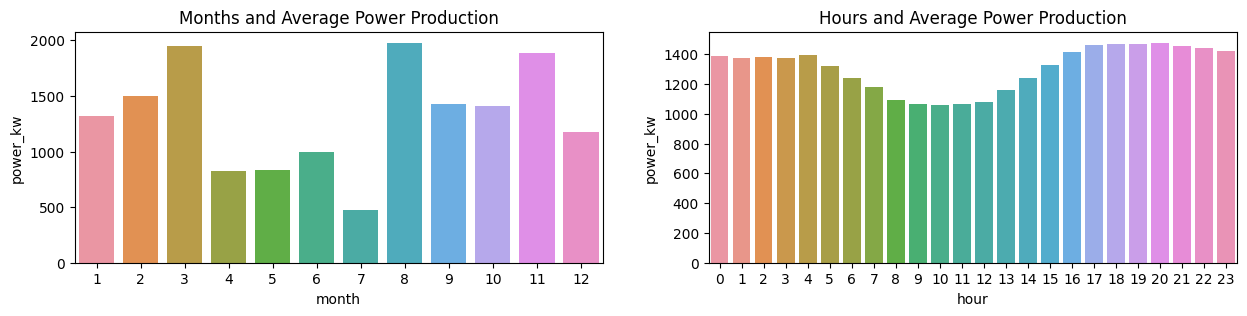

In [34]:
columns = ['month', 'hour']
i=1
plt.figure(figsize=(15,3))
for each in columns:
    avg_prod = df.groupby(each)[['power_kw']].mean().reset_index()
    plt.subplot(1,2,i)
    plt.title(f"{each.title()}s and Average Power Production")
    sns.barplot(x= each , y='power_kw', data=avg_prod)
    i += 1

# Data Prep for ML Algorithms

In [5]:
from sklearn import metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost.sklearn import XGBRegressor
from sklearn.ensemble import AdaBoostRegressor

### Defining the training features

In [2]:
df = pd.read_csv("df.csv")
df.head()

,power_kw,wind_speed_ms,theoretical_power_kw,wind_direction_deg,year,month,day,hour
0,380.047791,5.311336,416.328908,259.994904,2018,1,1,0
1,453.769196,5.672167,519.917511,268.641113,2018,1,1,0
2,306.376587,5.216037,390.900016,272.564789,2018,1,1,0
3,419.645905,5.659674,516.127569,271.258087,2018,1,1,0
4,380.650696,5.577941,491.702972,265.674286,2018,1,1,0


In [3]:
features = ['power_kw', 'wind_speed_ms', 'wind_direction_deg', 'month', 'day', 'hour'] #without theoretical power 

training_data = df[features]
X = training_data.drop(columns=['power_kw'], axis = 1).values
Y= training_data['power_kw'].values

### Train and Test data split

In [6]:
x_train , x_test , y_train , y_test = train_test_split(X, Y, test_size=0.20, random_state=1234)

print("Dimensions of train set:")
print(f"X_train: {x_train.shape}, Y_train: {y_train.shape}")
print("Dimensions of test set:")
print(f"X_test: {x_test.shape}, Y_test: {y_test.shape}")


Dimensions of train set:
X_train: (40424, 5), Y_train: (40424,)
Dimensions of test set:
X_test: (10106, 5), Y_test: (10106,)


# Model Training

In [7]:
def train_model( models, x_train, x_test, y_train, y_test):
    
    model = models
    model.fit(x_train,y_train)
    y_pred_test = model.predict(x_test)
    y_pred_train = model.predict(x_train)
    y_total_prediction = model.predict(X)
    
    print("\t\tError Table")
    print('Mean Absolute Error      : ', metrics.mean_absolute_error(y_test, y_pred_test))
    print('Mean Squared  Error      : ', metrics.mean_squared_error(y_test, y_pred_test))
    print('Root Mean Squared  Error : ', np.sqrt(metrics.mean_squared_error(y_test, y_pred_test)))
    print('Accuracy on Training set   : ', metrics.r2_score(y_train,y_pred_train))
    print('Accuracy on Testing set  : ', metrics.r2_score(y_test,y_pred_test))
    return y_total_prediction, model

In [8]:
def visualizing_power(y_total_prediction, y_actual):
    y_real = y_actual
    y_prediction = y_total_prediction
    TP = df['theoretical_power_kw']
    number = len(df['wind_speed_ms'])
    aa = [x for x in df['wind_speed_ms']]
    
    plt.figure(figsize=(21, 6))
    
    sns.scatterplot(x=aa, y=y_real[:number], color='cornflowerblue', label='Real Power Production', marker='o')
    sns.scatterplot(x=aa, y=y_prediction[:number], color='#3CB371', label='Predicted Power Production', alpha=0.3, marker='P')
    sns.lineplot(x='wind_speed_ms', y='theoretical_power_kw', color='crimson', label='Theoretical Power Production', data=df)
    
    plt.xlabel('Wind Speed (m/s)', size=10)
    plt.ylabel('Power Production (kW)', size=10)
    plt.title('Wind Turbine Power Production Prediction', size=20)
    plt.legend(fontsize=10)
    plt.show()


Decision Tree

In [41]:
y_predicted, DT = train_model(DecisionTreeRegressor(),  x_train , x_test , y_train , y_test) # without theo power
#visualizing_power(y_predicted, Y)

		Error Table
Mean Absolute Error      :  88.83368173613916
Mean Squared  Error      :  67650.31056670494
Root Mean Squared  Error :  260.0967330950255
Accuracy on Training set   :  1.0
Accuracy on Testing set  :  0.9611503002227381


In [42]:
y_predicted, DT = train_model(DecisionTreeRegressor(),  x_train , x_test , y_train , y_test) # without year feature
#visualizing_power(y_predicted, Y)

		Error Table
Mean Absolute Error      :  91.01435786555686
Mean Squared  Error      :  72736.95585181277
Root Mean Squared  Error :  269.697897381149
Accuracy on Training set   :  1.0
Accuracy on Testing set  :  0.9582291807105814


In [43]:
y_predicted, DT = train_model(DecisionTreeRegressor(),  x_train , x_test , y_train , y_test)
#visualizing_power(y_predicted, Y)

		Error Table
Mean Absolute Error      :  89.68633546811064
Mean Squared  Error      :  68082.63046374384
Root Mean Squared  Error :  260.92648478784946
Accuracy on Training set   :  1.0
Accuracy on Testing set  :  0.9609020308790055


XGBOOSTREG

In [44]:
y_predicted, XGBREG = train_model( XGBRegressor( ),  x_train , x_test , y_train , y_test) # without theo power
#visualizing_power(y_predicted, Y)

		Error Table
Mean Absolute Error      :  77.26629770728479
Mean Squared  Error      :  29818.665418329463
Root Mean Squared  Error :  172.68081948592166
Accuracy on Training set   :  0.9905758364524266
Accuracy on Testing set  :  0.9828759662807688


In [45]:
y_predicted, XGBREG = train_model( XGBRegressor( ),  x_train , x_test , y_train , y_test) # without year
#visualizing_power(y_predicted, Y)

		Error Table
Mean Absolute Error      :  77.26629770728479
Mean Squared  Error      :  29818.665418329463
Root Mean Squared  Error :  172.68081948592166
Accuracy on Training set   :  0.9905758364524266
Accuracy on Testing set  :  0.9828759662807688


In [46]:
y_predicted, XGBREG = train_model( XGBRegressor( ),  x_train , x_test , y_train , y_test)
#visualizing_power(y_predicted, Y)

		Error Table
Mean Absolute Error      :  77.26629770728479
Mean Squared  Error      :  29818.665418329463
Root Mean Squared  Error :  172.68081948592166
Accuracy on Training set   :  0.9905758364524266
Accuracy on Testing set  :  0.9828759662807688


XGB TUNED

In [47]:
# without theo power
params = {'learning_rate': 0.01, 'max_depth': 9, 'n_estimators': 500}
y_predicted, XGBREG_TUNED = train_model( XGBRegressor( **params),  x_train , x_test , y_train , y_test)
params = XGBREG_TUNED.get_params()
print(params)

		Error Table
Mean Absolute Error      :  75.92706742655983
Mean Squared  Error      :  32646.135582043404
Root Mean Squared  Error :  180.68241636098242
Accuracy on Training set   :  0.9908367663731062
Accuracy on Testing set  :  0.9812522284727784
{'objective': 'reg:squarederror', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'feature_types': None, 'gamma': None, 'gpu_id': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': 0.01, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': 9, 'max_leaves': None, 'min_child_weight': None, 'missing': nan, 'monotone_constraints': None, 'n_estimators': 500, 'n_jobs': None, 'num_parallel_tree': None, 'predictor': None, 'random_state': None, 'reg_alpha': None, 'reg_lambda': Non

In [48]:
# WITHOUT YEAR
params = {'learning_rate': 0.01, 'max_depth': 9, 'n_estimators': 500}
y_predicted, XGBREG_TUNED = train_model( XGBRegressor( **params),  x_train , x_test , y_train , y_test)
params = XGBREG_TUNED.get_params()
print(params)

		Error Table
Mean Absolute Error      :  75.92706742655983
Mean Squared  Error      :  32646.135582043404
Root Mean Squared  Error :  180.68241636098242
Accuracy on Training set   :  0.9908367663731062
Accuracy on Testing set  :  0.9812522284727784
{'objective': 'reg:squarederror', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'feature_types': None, 'gamma': None, 'gpu_id': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': 0.01, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': 9, 'max_leaves': None, 'min_child_weight': None, 'missing': nan, 'monotone_constraints': None, 'n_estimators': 500, 'n_jobs': None, 'num_parallel_tree': None, 'predictor': None, 'random_state': None, 'reg_alpha': None, 'reg_lambda': Non

In [49]:
params = {'learning_rate': 0.01, 'max_depth': 9, 'n_estimators': 500}
y_predicted, XGBREG_TUNED = train_model( XGBRegressor( **params),  x_train , x_test , y_train , y_test)
params = XGBREG_TUNED.get_params()
print(params)

		Error Table
Mean Absolute Error      :  75.92706742655983
Mean Squared  Error      :  32646.135582043404
Root Mean Squared  Error :  180.68241636098242
Accuracy on Training set   :  0.9908367663731062
Accuracy on Testing set  :  0.9812522284727784
{'objective': 'reg:squarederror', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'feature_types': None, 'gamma': None, 'gpu_id': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': 0.01, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': 9, 'max_leaves': None, 'min_child_weight': None, 'missing': nan, 'monotone_constraints': None, 'n_estimators': 500, 'n_jobs': None, 'num_parallel_tree': None, 'predictor': None, 'random_state': None, 'reg_alpha': None, 'reg_lambda': Non

EXTREE

In [50]:
y_predicted, XTREE = train_model( ExtraTreesRegressor(),  x_train , x_test , y_train , y_test) # without theo power
#visualizing_power(y_predicted, Y)

		Error Table
Mean Absolute Error      :  68.12675449977536
Mean Squared  Error      :  29540.437435543095
Root Mean Squared  Error :  171.87331798607687
Accuracy on Training set   :  0.9999999999999982
Accuracy on Testing set  :  0.983035744905735


In [51]:
y_predicted, XTREE = train_model( ExtraTreesRegressor(),  x_train , x_test , y_train , y_test) # without year
#visualizing_power(y_predicted, Y)

		Error Table
Mean Absolute Error      :  67.09235447086286
Mean Squared  Error      :  28755.78865939241
Root Mean Squared  Error :  169.5753185442752
Accuracy on Training set   :  0.9999999999999996
Accuracy on Testing set  :  0.9834863469669626


In [52]:
y_predicted, XTREE = train_model( ExtraTreesRegressor(),  x_train , x_test , y_train , y_test)
#visualizing_power(y_predicted, Y)

		Error Table
Mean Absolute Error      :  67.5576313018421
Mean Squared  Error      :  28992.509395055433
Root Mean Squared  Error :  170.2718690654902
Accuracy on Training set   :  0.9999999999999999
Accuracy on Testing set  :  0.9833504048044726


RANDOM FOREST

In [53]:
# baseline
y_predicted, RFOREST = train_model( RandomForestRegressor(),  x_train , x_test , y_train , y_test) # without theo power
#visualizing_power(y_predicted, Y) 

		Error Table
Mean Absolute Error      :  72.20846849981427
Mean Squared  Error      :  34660.66531828015
Root Mean Squared  Error :  186.1737503470351
Accuracy on Training set   :  0.9966023137237482
Accuracy on Testing set  :  0.9800953398378327


In [54]:
# baseline
y_predicted, RFOREST = train_model( RandomForestRegressor(),  x_train , x_test , y_train , y_test)
#visualizing_power(y_predicted, Y) 

		Error Table
Mean Absolute Error      :  72.04201082392898
Mean Squared  Error      :  34309.25825505381
Root Mean Squared  Error :  185.22758502732202
Accuracy on Training set   :  0.9966223443427883
Accuracy on Testing set  :  0.9802971431819946


In [55]:
# from hyperopt import hp
# from hyperopt import fmin, tpe, STATUS_OK, STATUS_FAIL, Trials
# from sklearn.model_selection import cross_val_score
# from sklearn.ensemble import RandomForestRegressor

# num_estimator = [100,150,200,250]

# space=  {'max_depth': hp.quniform("max_depth", 3, 18, 1),
#         'min_samples_split': hp.quniform('min_samples_split', 2, 10, 1),
#         'min_samples_leaf': hp.quniform('min_samples_leaf', 1, 10, 1),
#         'max_features': hp.choice('max_features', ['sqrt', 'log2']),
#         'n_estimators': hp.choice("n_estimators", num_estimator)
#     }

# def hyperparameter_tuning(space):
#     model = RandomForestRegressor(n_estimators = space['n_estimators'], max_depth = int(space['max_depth']),
#                                    min_samples_split = int(space['min_samples_split']),
#                                    min_samples_leaf = int(space['min_samples_leaf']),
#                                    max_features = space['max_features'], random_state=42)
    
#     score_cv = cross_val_score(model, x_train, y_train, cv=5, scoring="neg_mean_absolute_error").mean()
#     return {'loss':-score_cv, 'status': STATUS_OK, 'model': model}


# trials = Trials()
# best = fmin(fn=hyperparameter_tuning,
#             space=space,
#             algo=tpe.suggest,
#             max_evals=200,
#             trials=trials)

# print(best)


Random Forest Somewhat Tuned

In [9]:
# without theo power
y_predicted, RFOREST = train_model( RandomForestRegressor(n_estimators=350,min_samples_split=2,min_samples_leaf=1,max_features='sqrt',max_depth=25),  x_train , x_test , y_train , y_test)
#visualizing_power(y_predicted, Y) 

		Error Table
Mean Absolute Error      :  59.40446950039476
Mean Squared  Error      :  22594.322002225686
Root Mean Squared  Error :  150.31407785774985
Accuracy on Training set   :  0.9978006335066321
Accuracy on Testing set  :  0.987024706625822


In [57]:
# import pickle

# # Train and get the best random forest model

# # Save the trained model to a file
# with open('best_rf.pickle', 'wb') as f:
#     pickle.dump(RFOREST, f)


In [58]:
# import bz2file as bz2
# import pickle
# import numpy as np
# from sklearn.ensemble import RandomForestRegressor

# # Define a function to save the model using bz2file and pickle
# def compressed_pickle(title, data):
#     with bz2.BZ2File(title + '.pbz2', 'w') as f:
#         pickle.dump(data, f)

# # Save the model to a compressed pickle file
# compressed_pickle('best_rf', RFOREST)


In [59]:
#WITHOUT YEAR
y_predicted, RFOREST = train_model( RandomForestRegressor(n_estimators=350,min_samples_split=2,min_samples_leaf=1,max_features='sqrt',max_depth=25),  x_train , x_test , y_train , y_test)
#visualizing_power(y_predicted, Y) 

		Error Table
Mean Absolute Error      :  59.277364808560726
Mean Squared  Error      :  22394.912872541496
Root Mean Squared  Error :  149.64929960591695
Accuracy on Training set   :  0.9977670309593333
Accuracy on Testing set  :  0.9871392217663465


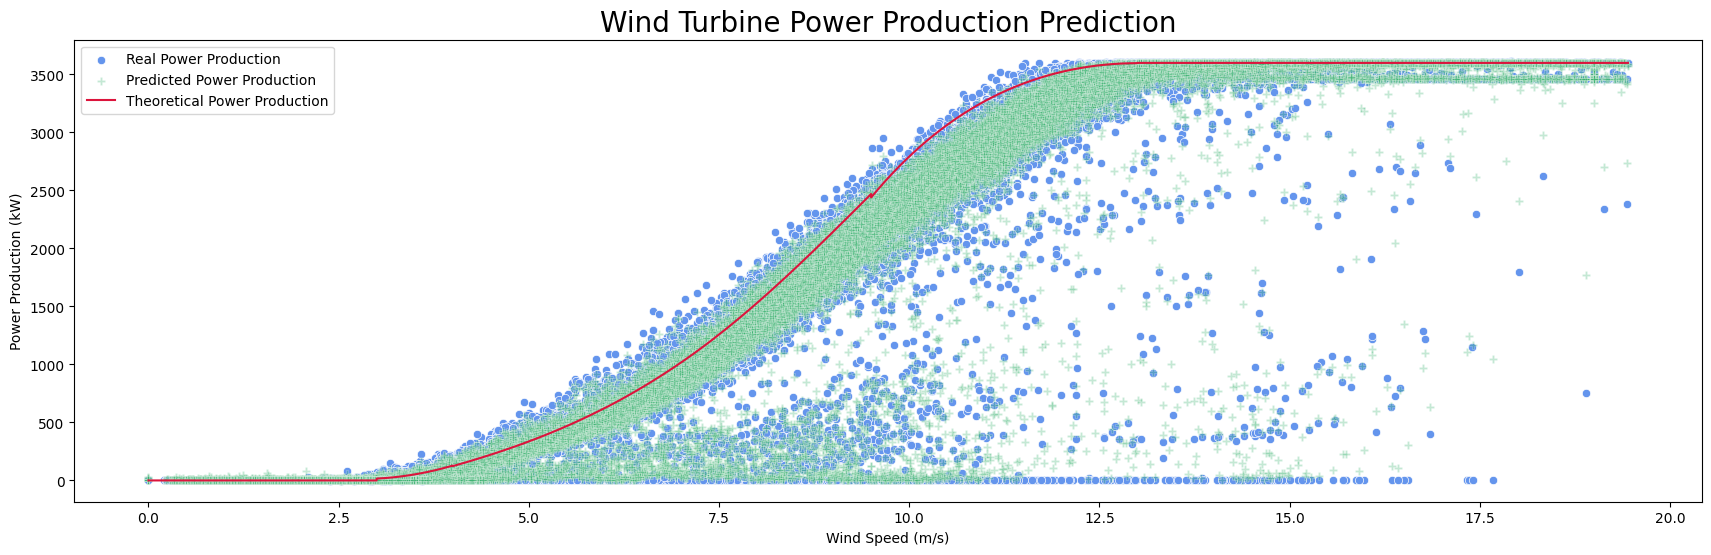

In [60]:
visualizing_power(y_predicted, Y)

KNN

In [61]:
y_predicted, KNN = train_model( KNeighborsRegressor(),  x_train , x_test , y_train , y_test)
#visualizing_power(y_predicted, Y)

		Error Table
Mean Absolute Error      :  153.89825783543282
Mean Squared  Error      :  76229.19844258537
Root Mean Squared  Error :  276.09635717007455
Accuracy on Training set   :  0.9740508889156694
Accuracy on Testing set  :  0.956223682508661


ADA

In [62]:
y_predicted, ADA = train_model( AdaBoostRegressor(n_estimators=20,learning_rate=0.5),  x_train , x_test , y_train , y_test)
#visualizing_power(y_predicted, Y)

		Error Table
Mean Absolute Error      :  278.5853430420544
Mean Squared  Error      :  200054.508735903
Root Mean Squared  Error :  447.2745339675656
Accuracy on Training set   :  0.8807029924806012
Accuracy on Testing set  :  0.8851142361598768


GDBR

In [63]:
#y_predicted, GDBR = train_model(GradientBoostingRegressor(random_state=21, n_estimators=2000),  x_train , x_test , y_train , y_test)
#visualizing_power(y_predicted, Y)

param_grid = {
    'learning_rate': [0.01, 0.1],
    'n_estimators': [100, 500, 1000],
    'max_depth': [3, 5, 7]
}

xgb = XGBRegressor(random_state=1234)
grid_search = GridSearchCV(xgb, param_grid, cv=5, n_jobs=-1)
grid_search.fit(x_train, y_train)

best_params = grid_search.best_params_
print('Best hyperparameters:', best_params)

xgb_tuned = XGBRegressor(random_state=1234, **best_params)
y_predicted = train_model(xgb_tuned, x_train, x_test, y_train, y_test)

In [64]:
# sns.set_style("whitegrid")
# plt.figure(figsize=(20,10))
# plt.plot(Y[0:100], label="True")
# plt.plot(y_predicted[0:100], label="Predicted")
# plt.legend(loc='upper right')
# plt.xlabel("data points")
# plt.ylabel("Power generated by system (kW)")
# plt.show()